# Install required packages

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn xgboost statsmodels tensorflow



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Loading and Initial Exploration

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the dataset
df = pd.read_csv("hour.csv")
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (17379, 17)

Columns: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

First few rows:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Dataset Description

 | Field        | Description                                                                                       |
 |--------------|---------------------------------------------------------------------------------------------------|
 | instant      | Record index                                                                                      |
 | dteday       | Date                                                                                              |
 | season       | Season (1: Winter, 2: Spring, 3: Summer, 4: Fall)                                                |
 | yr           | Year (0: 2011, 1: 2012)                                                                          |
 | mnth         | Month (1 to 12)                                                                                   |
 | hr           | Hour (0 to 23)                                                                                    |
 | holiday      | Weather day is holiday or not (extracted from [Web Link])                                         |
 | weekday      | Day of the week                                                                                    |
 | workingday   | 1 if the day is neither weekend nor holiday, else 0                                              |
 | weathersit   | Weather situation:                                                                                 |
 |              | 1: Clear, Few clouds, Partly cloudy                                                              |
 |              | 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                                   |
 |              | 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds       |
 |              | 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                     |
 | temp         | Normalized temperature in Celsius: `(t - t_min)/(t_max - t_min)`, t_min=-8, t_max=39             |
 | atemp        | Normalized feeling temperature in Celsius: `(t - t_min)/(t_max - t_min)`, t_min=-16, t_max=50    |
 | hum          | Normalized humidity (divided by 100)                                                             |
 | windspeed    | Normalized wind speed (divided by 67)                                                            |
 | casual       | Count of casual users                                                                             |
 | registered   | Count of registered users                                                                         |
 | cnt          | Count of total rental bikes (casual + registered)                                                |


# Rename Columns

In [135]:
df = df.rename(columns={'dteday':'ds', 'cnt':'y'})
df['ds'] = pd.to_datetime(df['ds'])


# Create time-based features

In [136]:
from sklearn.preprocessing import LabelEncoder

# Lag features
df['y_lag1'] = df['y'].shift(1)
df['y_lag7'] = df['y'].shift(7)
df['y_roll7'] = df['y'].rolling(7).mean()

# Date features
df['dayofweek'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df['hour'] = df['hr']

# Label encode weekday
le = LabelEncoder()
df['weekday_encoded'] = le.fit_transform(df['weekday'])

# Create rush hour feature
def is_rush_hour(hour):
    if (7 <= hour <= 9) or (16 <= hour <= 19):
        return 1
    else:
        return 0

df['rush_hour'] = df['hr'].apply(is_rush_hour)

# Drop rows with NaN values from lag features
df = df.dropna()

print("Preprocessed dataset shape:", df.shape)
df[['ds', 'y', 'y_lag1', 'y_lag7', 'y_roll7', 'rush_hour']].head()




Preprocessed dataset shape: (17372, 25)


,ds,y,y_lag1,y_lag7,y_roll7,rush_hour
7,2011-01-01,3,2.0,16.0,13.142857,1
8,2011-01-01,8,3.0,40.0,8.571429,1
9,2011-01-01,14,8.0,32.0,6.000000,1
10,2011-01-01,36,14.0,13.0,9.285714,0
11,2011-01-01,56,36.0,1.0,17.142857,0


# Visualization of Rush Hour 

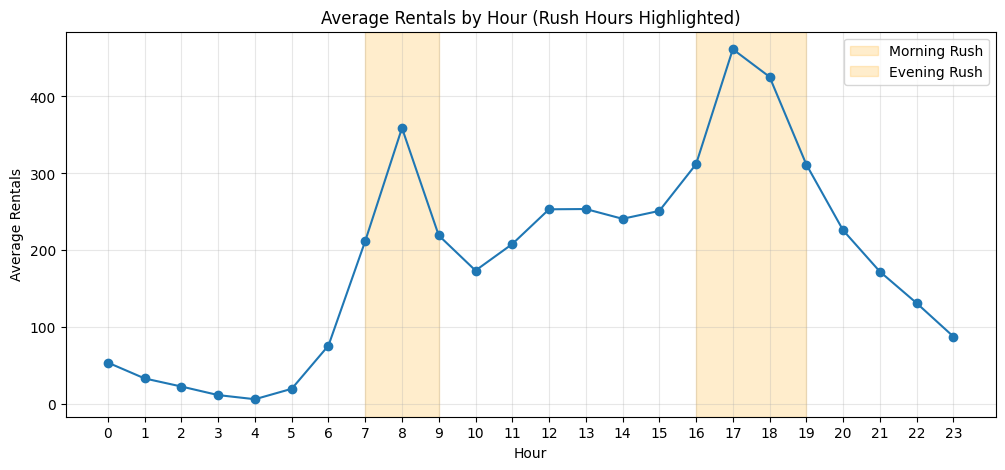

In [137]:
import matplotlib.pyplot as plt

hourly_mean = df.groupby('hr')['y'].mean()

plt.figure(figsize=(12,5))
plt.plot(hourly_mean.index, hourly_mean.values, marker='o')
plt.axvspan(7, 9, color='orange', alpha=0.2, label='Morning Rush')
plt.axvspan(16, 19, color='orange', alpha=0.2, label='Evening Rush')
plt.title("Average Rentals by Hour (Rush Hours Highlighted)")
plt.xlabel("Hour")
plt.ylabel("Average Rentals")
plt.xticks(range(0,24))
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Correlation Matrix

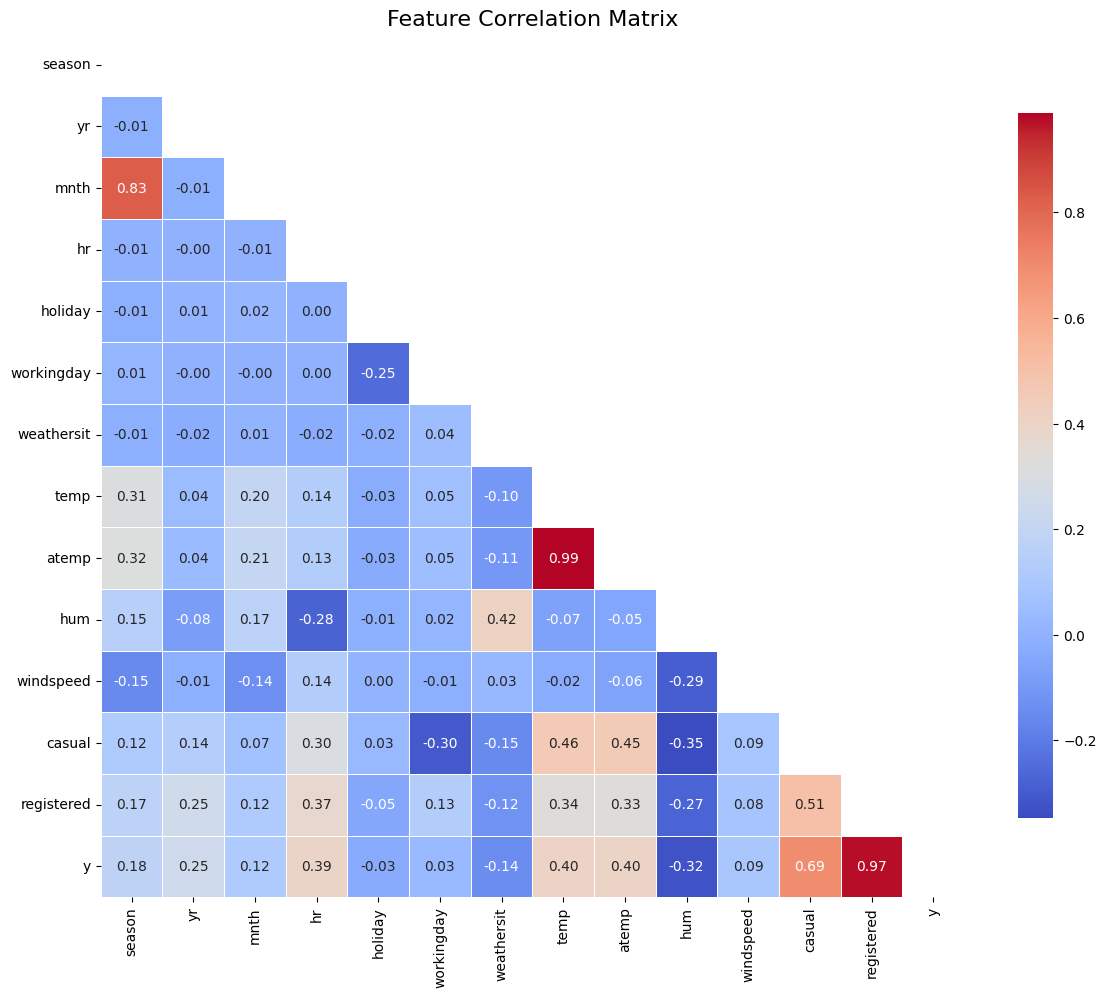

In [138]:
plt.figure(figsize=(12, 10))
numerical_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 
                      'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'y']
corr_matrix = df[numerical_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

# Feature Importance Analysis

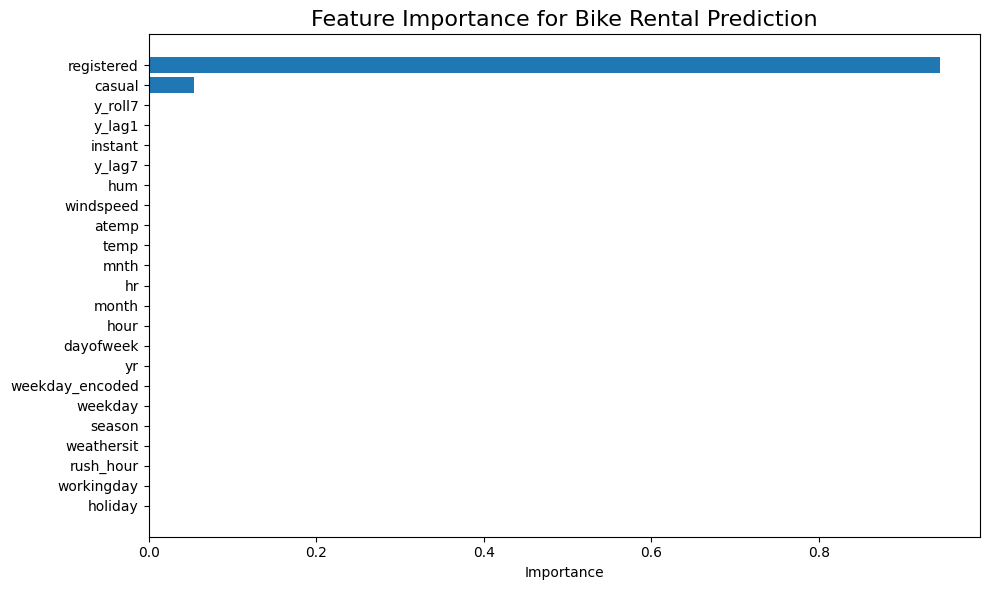

Top 5 Important Features:
       feature  importance
14  registered    0.945328
13      casual    0.053795
17     y_roll7    0.000312
15      y_lag1    0.000159
0      instant    0.000116


In [139]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare features for feature importance analysis
features = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y_lag1', 'y_lag7', 'y_roll7', 'dayofweek',
       'month', 'hour', 'weekday_encoded', 'rush_hour']
X = df[features]
y = df['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Bike Rental Prediction', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 5 Important Features:")
print(feature_importance.head())


# Random Forest Model

RMSE: 8.94, MAE: 2.72


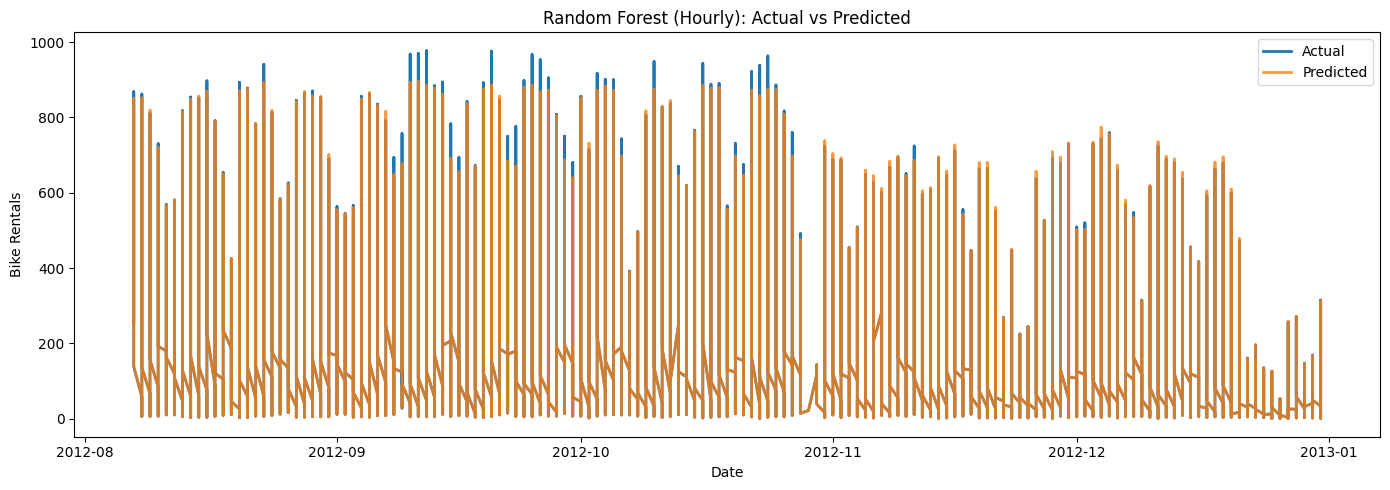

In [148]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Features & target

# Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
#        'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
#        'casual', 'registered', 'y_lag1', 'y_lag7', 'y_roll7', 'dayofweek',
#        'month', 'hour', 'weekday_encoded', 'rush_hour'],
#       dtype='object')

# X = df.drop(columns=['y', 'ds', 'atemp', 'instant', 'windspeed', 'registered', 'casual'])
# y = df['y']
# print(X.columns)
# print(y.columns)

rf_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 
               'y_lag1', 'y_lag7', 'y_roll7', 'dayofweek', 'rush_hour']

X_rf = df[rf_features]
y_rf = df['y']

# Split 80% train, 20% test
split_idx = int(len(df)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

plt.figure(figsize=(14,5))

plt.plot(
    df.loc[y_test.index, 'ds'],
    y_test,
    label='Actual',
    linewidth=2
)

plt.plot(
    df.loc[y_test.index, 'ds'],
    y_pred,
    label='Predicted',
    linewidth=2,
    alpha=0.8
)

plt.legend()
plt.title("Random Forest (Hourly): Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Bike Rentals")
plt.tight_layout()
plt.show()



Available columns in df:
['instant', 'ds', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'y', 'y_lag1', 'y_lag7', 'y_roll7', 'dayofweek', 'month', 'hour', 'weekday_encoded', 'rush_hour']

Using 14 features for prediction:
['season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'y_lag1', 'y_lag7', 'y_roll7', 'dayofweek', 'rush_hour']

X shape: (17372, 14), y shape: (17372,)
Training samples: 13897
Testing samples: 3475

Hourly Prediction Performance:
RMSE: 42.72
MAE: 26.22
R² Score: 0.9625
Average hourly rentals: 189.53
RMSE as % of mean: 22.54%


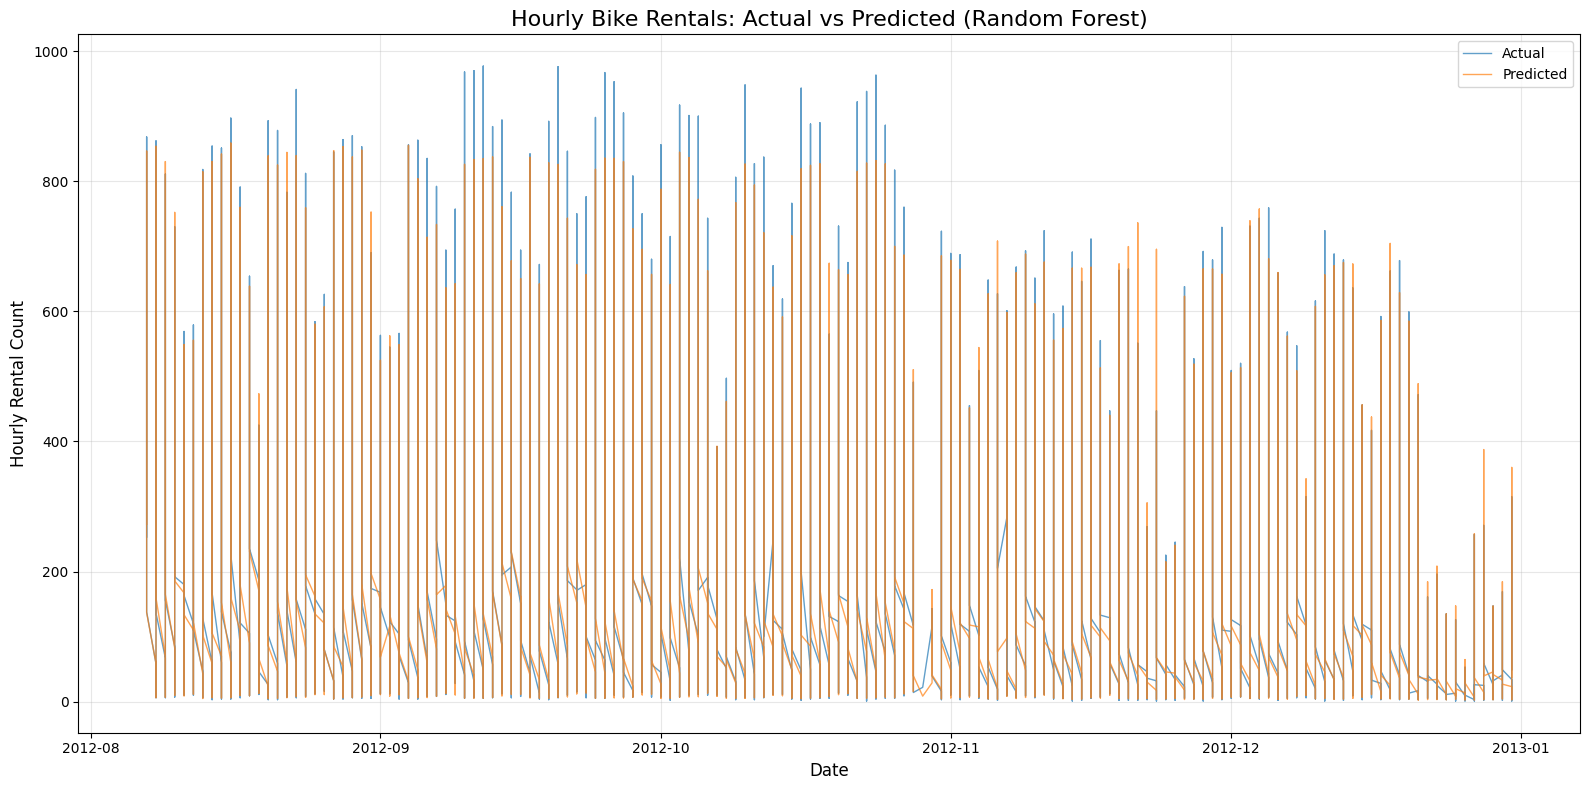

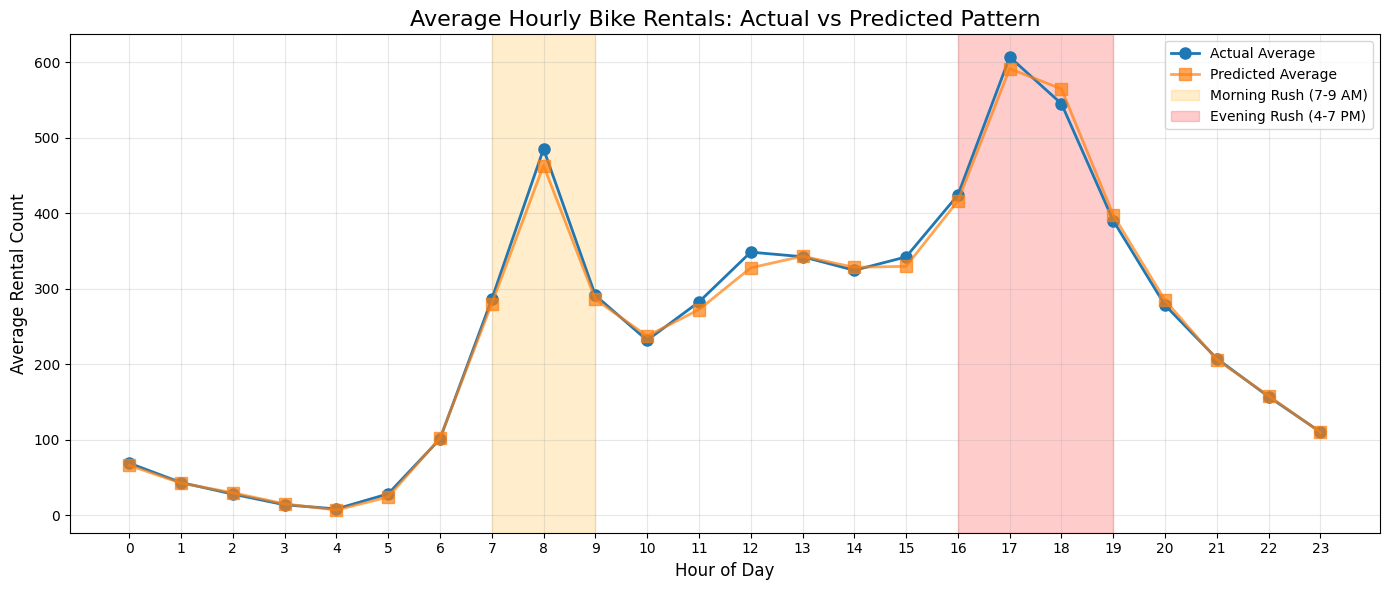

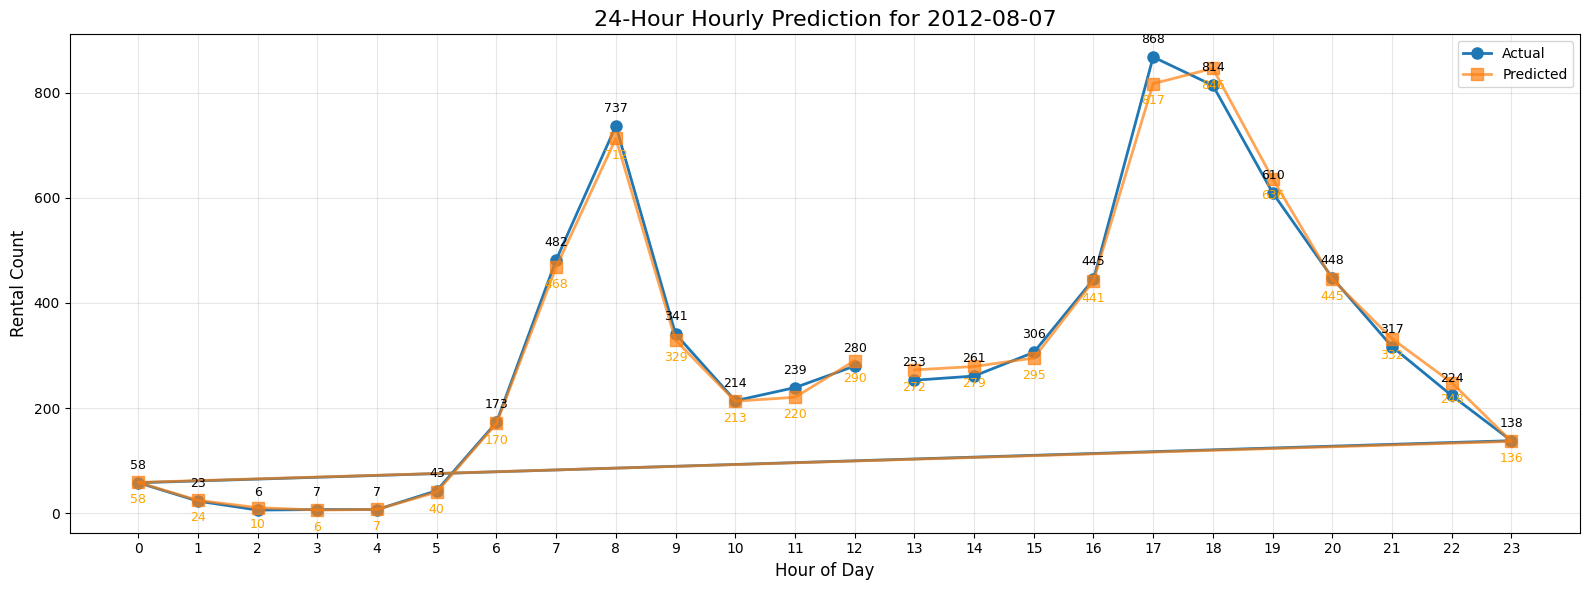


HOURLY PREDICTION PERFORMANCE ANALYSIS

Performance by Hour of Day:
    hour  actual  predicted  abs_error  percent_error
0      0   69.29      66.25      13.58          22.90
1      1   43.60      42.86      10.41          31.42
2      2   28.28      30.04       6.95          48.38
3      3   14.13      15.38       4.55          51.15
4      4    8.63       7.12       2.80          32.91
5      5   28.60      24.50       7.10          29.78
6      6  101.22     102.28      10.34          17.78
7      7  286.36     280.56      16.09          12.65
8      8  485.34     463.40      33.27          10.86
9      9  291.43     286.21      31.35          13.75
10    10  232.00     237.62      29.17          18.96
11    11  282.70     272.53      32.35          13.84
12    12  348.70     327.90      32.17          11.38
13    13  342.64     343.31      34.68          12.92
14    14  324.64     328.61      25.67           9.54
15    15  342.40     329.89      34.81          14.06
16    16  424

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Print available columns to verify
print("Available columns in df:")
print(df.columns.tolist())

# Select features for hourly prediction
# These features should help predict hourly demand
hourly_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 
               'y_lag1', 'y_lag7', 'y_roll7', 'dayofweek', 'rush_hour']

# Check if all features exist in dataframe
missing_features = [f for f in hourly_features if f not in df.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    # Remove missing features
    hourly_features = [f for f in hourly_features if f in df.columns]

print(f"\nUsing {len(hourly_features)} features for prediction:")
print(hourly_features)

# Prepare data
X = df[hourly_features]
y = df['y']  # This is hourly rental count

print(f"\nX shape: {X.shape}, y shape: {y.shape}")

# Time-based split (80% train, 20% test)
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_test = df['ds'][split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Train Random Forest for hourly prediction
rf = RandomForestRegressor(
    n_estimators=200,
    #max_depth=15,  # Increased for more complex hourly patterns
   # min_samples_split=5,
   # min_samples_leaf=2,
    #max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nHourly Prediction Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Average hourly rentals: {y.mean():.2f}")
print(f"RMSE as % of mean: {(rmse/y.mean()*100):.2f}%")

# ===========================================================================
# VISUALIZATION 1: Actual vs Predicted Over Time
# ===========================================================================
plt.figure(figsize=(16, 8))

# Plot actual vs predicted
plt.plot(dates_test.values, y_test.values, label='Actual', alpha=0.7, linewidth=1)
plt.plot(dates_test.values, y_pred, label='Predicted', alpha=0.7, linewidth=1)

plt.title("Hourly Bike Rentals: Actual vs Predicted (Random Forest)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Hourly Rental Count", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Create a DataFrame for easier analysis
results_df = pd.DataFrame({
    'datetime': dates_test.values,
    'actual': y_test.values,
    'predicted': y_pred,
    'hour': df['hr'][split_idx:].values,
    'dayofweek': df['dayofweek'][split_idx:].values
})

# Extract hour from datetime
results_df['hour_only'] = results_df['datetime'].astype(str).str[11:13]

# Calculate average actual and predicted by hour
hourly_avg = results_df.groupby('hour').agg({
    'actual': 'mean',
    'predicted': 'mean'
}).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(hourly_avg['hour'], hourly_avg['actual'], 'o-', label='Actual Average', linewidth=2, markersize=8)
plt.plot(hourly_avg['hour'], hourly_avg['predicted'], 's-', label='Predicted Average', linewidth=2, markersize=8, alpha=0.7)

# Highlight rush hours
plt.axvspan(7, 9, color='orange', alpha=0.2, label='Morning Rush (7-9 AM)')
plt.axvspan(16, 19, color='red', alpha=0.2, label='Evening Rush (4-7 PM)')

plt.title("Average Hourly Bike Rentals: Actual vs Predicted Pattern", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Rental Count", fontsize=12)
plt.xticks(range(0, 24))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Let's predict a specific day from the test set
if len(results_df) >= 24:
    # Take first complete day from test set
    one_day_data = results_df.iloc[:24]
    
    plt.figure(figsize=(16, 6))
    
    hours = one_day_data['hour']
    plt.plot(hours, one_day_data['actual'], 'o-', label='Actual', linewidth=2, markersize=8)
    plt.plot(hours, one_day_data['predicted'], 's-', label='Predicted', linewidth=2, markersize=8, alpha=0.7)
    
    # Annotate points with values
    for i, (act, pred, hour) in enumerate(zip(one_day_data['actual'], one_day_data['predicted'], hours)):
        plt.annotate(f'{int(act)}', (hour, act), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
        plt.annotate(f'{int(pred)}', (hour, pred), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, color='orange')
    
    plt.title(f"24-Hour Hourly Prediction for {one_day_data['datetime'].iloc[0].date()}", fontsize=16)
    plt.xlabel("Hour of Day", fontsize=12)
    plt.ylabel("Rental Count", fontsize=12)
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


print("\n" + "="*60)
print("HOURLY PREDICTION PERFORMANCE ANALYSIS")
print("="*60)

# Calculate hourly error metrics by time of day
results_df['abs_error'] = np.abs(results_df['actual'] - results_df['predicted'])
results_df['percent_error'] = np.abs(results_df['actual'] - results_df['predicted']) / results_df['actual'] * 100

# Remove infinite values from percent error calculation
results_df['percent_error'] = results_df['percent_error'].replace([np.inf, -np.inf], np.nan)

hourly_metrics = results_df.groupby('hour').agg({
    'actual': 'mean',
    'predicted': 'mean',
    'abs_error': 'mean',
    'percent_error': 'mean'
}).reset_index()

print("\nPerformance by Hour of Day:")
print(hourly_metrics.round(2))

# Worst predicted hours
worst_hours = hourly_metrics.nlargest(5, 'abs_error')[['hour', 'abs_error', 'percent_error']]
print(f"\nMost Difficult Hours to Predict (Highest Absolute Error):")
print(worst_hours.round(2))

# Best predicted hours
best_hours = hourly_metrics.nsmallest(5, 'abs_error')[['hour', 'abs_error', 'percent_error']]
print(f"\nEasiest Hours to Predict (Lowest Absolute Error):")
print(best_hours.round(2))


# Create comprehensive results dataframe
detailed_results = pd.DataFrame({
    'datetime': dates_test.values,
    'actual_hourly_rentals': y_test.values,
    'predicted_hourly_rentals': y_pred,
    'hour': df['hr'][split_idx:].values,
    'day_of_week': df['dayofweek'][split_idx:].values,
    'abs_error': np.abs(y_test.values - y_pred),
    'percent_error': np.abs(y_test.values - y_pred) / y_test.values * 100
})



In [151]:
# Let's calculate the actual average from your results
hourly_avg = [69.29, 43.60, 28.28, 14.13, 8.63, 28.60, 101.22, 286.36, 485.34, 
              291.43, 232.00, 282.70, 348.70, 342.64, 324.64, 342.40, 424.29, 
              607.14, 545.20, 390.36, 278.35, 207.69, 157.30, 110.47]

actual_average = sum(hourly_avg) / len(hourly_avg)
print(f"Actual average hourly demand: {actual_average:.2f} bikes")

Actual average hourly demand: 247.95 bikes


# XGBoost Model

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}

XGBoost Performance:
RMSE: 9.96
MAE: 3.52


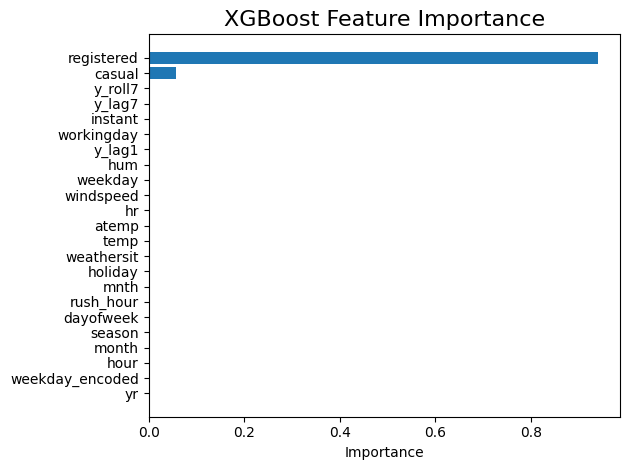

In [149]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Prepare data for XGBoost
X_xgb = X_rf  # Using same features as RF
y_xgb = y_rf

# Split data
X_train_xgb, X_test_xgb = X_train, X_test
y_train_xgb, y_test_xgb = y_train, y_test

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Define parameter grid for tuning
xgb_params = {
    'n_estimators': [300],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search
xgb_grid = GridSearchCV(
    xgb_model,
    xgb_params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_xgb, y_train_xgb)

# Get best model
best_xgb = xgb_grid.best_estimator_
print(f"Best XGBoost Parameters: {xgb_grid.best_params_}")

# Make predictions
y_pred_xgb = best_xgb.predict(X_test_xgb)

# Calculate metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
xgb_mae = mean_absolute_error(y_test_xgb, y_pred_xgb)


print("\nXGBoost Performance:")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAE: {xgb_mae:.2f}")

# Plot feature importance for XGBoost
xgb_importance = pd.DataFrame({
    'feature': X_train_xgb.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=True)


plt.barh(xgb_importance['feature'], xgb_importance['importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.tight_layout()
plt.show()

 # LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM
lstm_features = ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'dayofweek', 'rush_hour']
X_lstm = df[lstm_features].values
y_lstm = df['y'].values.reshape(-1, 1)

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_lstm)
y_scaled = scaler_y.fit_transform(y_lstm)

# Create sequences
def create_sequences(X, y, time_steps=24):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

TIME_STEPS = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# Split data
split_idx = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

lstm_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Make predictions
y_pred_scaled = lstm_model.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_true_lstm = scaler_y.inverse_transform(y_test_seq)

# Calculate metrics
lstm_rmse = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
lstm_mae = mean_absolute_error(y_true_lstm, y_pred_lstm)
lstm_r2 = r2_score(y_true_lstm, y_pred_lstm)

print("LSTM Performance:")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAE: {lstm_mae:.2f}")
print(f"R²: {lstm_r2:.4f}")

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(y_true_lstm[:500], label='Actual', alpha=0.7)
plt.plot(y_pred_lstm[:500], label='LSTM Predicted', alpha=0.7)
plt.title("LSTM: Actual vs Predicted (First 500 samples)", fontsize=16)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Rental Count", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [118]:

import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt



# --- Train-test split ---
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- Random Forest & XGBoost training (GridSearch) ---
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

rf_params = {'n_estimators':[300], 'max_depth':[10], 'min_samples_split':[10], 'min_samples_leaf':[1], 'max_features':['sqrt']}
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, n_jobs=-1)
rf.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {'n_estimators':[300],'max_depth':[6,8,10],'learning_rate':[0.05,0.1],'subsample':[0.8,1],'colsample_bytree':[0.8,1]}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# --- Stacking Ensemble ---
estimators = [('rf', rf.best_estimator_), ('xgb', xgb_grid.best_estimator_)]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), n_jobs=-1)
stack.fit(X_train, y_train)

# --- Recursive Forecast for Next 30 Days ---
future_days = 30
last_date = df['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)
future_preds = []

# Copy last 7 days of y for lag calculations
last_7_y = df['y'].iloc[-7:].tolist()

for i in range(future_days):
    row = {}
    date = future_dates[i]
    
    # Calendar features
    row['mnth'] = date.month
    row['dayofweek'] = date.dayofweek
    row['hr'] = 0  # set default hour for daily forecast
    row['rush_hour'] = 1 if row['hr'] in [7,8,9,17,18,19] else 0

    # Weather features (last known values)
    row['season'] = df['season'].iloc[-1]
    row['holiday'] = df['holiday'].iloc[-1]
    row['workingday'] = df['workingday'].iloc[-1]
    row['weathersit'] = df['weathersit'].iloc[-1]
    row['temp'] = df['temp'].iloc[-1]
    row['atemp'] = df['atemp'].iloc[-1]
    row['hum'] = df['hum'].iloc[-1]
    row['windspeed'] = df['windspeed'].iloc[-1]
    row['yr'] = df['yr'].iloc[-1]

    # Lag features
    row['y_lag1'] = last_7_y[-1]
    row['y_lag7'] = last_7_y[0]
    row['y_roll7'] = np.mean(last_7_y)
    row['casual'] = df['casual'].iloc[-1]
    row['registered'] = df['registered'].iloc[-1]

    # Predict
    row_df = pd.DataFrame([row])[features]
    y_pred = stack.predict(row_df)[0]
    future_preds.append(y_pred)

    last_7_y.pop(0)
    last_7_y.append(y_pred)


# --- Combine predictions with dates ---
future_df = pd.DataFrame({'ds': future_dates, 'y_pred': future_preds})
print(future_df)

# --- Optional: plot the forecast ---
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df['ds'], df['y'], label='Historical')
plt.plot(future_df['ds'], future_df['y_pred'], label='Forecast (30 days)', color='red')
plt.legend()
plt.title("Stacked Ensemble Forecast for Next 30 Days")
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- atemp
- casual
- dayofweek
- instant
- month
- ...
